# RNNs for time-series
March 2nd 2022

In [5]:
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import os
print(os.getcwd())
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/home/razielar/miniconda3/envs/time-series/bin/python
/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/coursera_time_series/week_4/1_NN_ts


In [2]:
# Custom functions:
import src.colorsetup

## Input data

In [44]:
data_path= 'course_data/FiveCitiesPM/'
df_beijing= pd.read_csv(data_path+'Beijing.csv')
df_beijing= df_beijing[df_beijing.year >= 2015]
print(df_beijing.shape)
df_beijing.head()

(8760, 18)


,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0


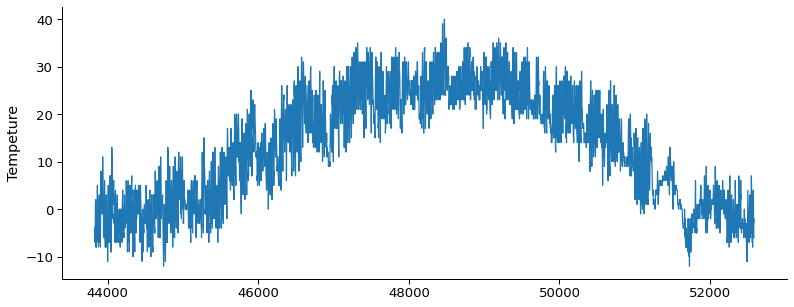

In [45]:
plt.plot(df_beijing['TEMP'])
plt.ylabel("Tempeture")
plt.show()

In [46]:
# There're some missing data, so we're going to interpolate those missing values
# Interpolate through a linear funciton
print("Number of NaN in PM_Dongsi: {}".format(df_beijing['PM_Dongsi'].isnull().sum()))
print("Number of NaN in TEMP: {}".format(df_beijing['TEMP'].isnull().sum()))
df_beijing['PM_Dongsi']= df_beijing['PM_Dongsi'].interpolate()
df_beijing['TEMP'] = df_beijing['TEMP'].interpolate()
display(df_beijing[['PM_Dongsi']].head())
print("Number of NaN in PM_Dongsi: {}".format(df_beijing['PM_Dongsi'].isnull().sum()))

Number of NaN in PM_Dongsi: 164
Number of NaN in TEMP: 5


,PM_Dongsi
43824,5.0
43825,4.0
43826,3.0
43827,4.0
43828,3.0


Number of NaN in PM_Dongsi: 0


In [47]:
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])

In [50]:
df_beijing['date']= df_beijing.apply(make_date, axis= 1)
df_beijing.set_index(df_beijing.date, inplace= True)

In [51]:
df_beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,date
date,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0,2015-01-01 00:00:00
2015-01-01 01:00:00,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0,2015-01-01 01:00:00
2015-01-01 02:00:00,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0,2015-01-01 02:00:00
2015-01-01 03:00:00,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0,2015-01-01 03:00:00
2015-01-01 04:00:00,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0,2015-01-01 04:00:00


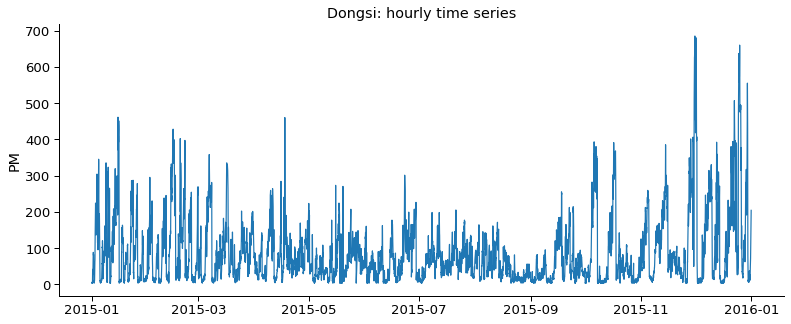

In [55]:
# plot
plt.plot(df_beijing['PM_Dongsi'])
plt.title("Dongsi: hourly time series")
plt.ylabel("PM")
plt.show()

In [70]:
# This's an hourly time series, so each day has 24 time steps
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    return df[series_name][-(24*n_days):]

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series
    """
    plt.plot(get_n_last_days(df, series_name, n_days))
    plt.xlabel('Recorded hour')
    plt.title("{0}: Air quality - {1} days".format(series_name, n_days))
    plt.grid(alpha= 0.4)

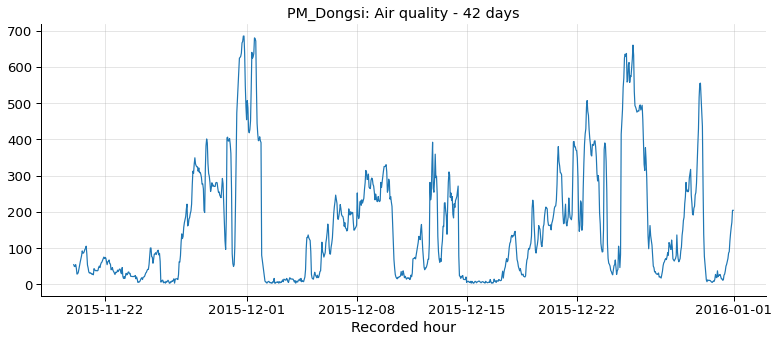

In [72]:
# Let's see the last 6 weeks
plot_n_last_days(df= df_beijing, series_name= 'PM_Dongsi', n_days= 7*6)

We observe some periocidity and Autocorrelation structure

## Start RNN